In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
combined_data_path = "/content/drive/MyDrive/shelter_neighbourhood_features_pca.csv"
non_pca_data_path = "/content/shelter_neighbourhood_features.csv"


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

def load_data(include_capacity=True):
    occupancy_data_2023 = pd.read_csv("../data/occupancy/Daily_shelter_overnight_occupancy.csv", low_memory=False)
    occupancy_data_2021 = pd.read_csv("../data/occupancy/daily-shelter-overnight-service-occupancy-capacity-2021.csv",
                                      low_memory=False)
    occupancy_data_2022 = pd.read_csv("../data/occupancy/daily-shelter-overnight-service-occupancy-capacity-2022.csv",
                                      low_memory=False)
    occupancy_data_2022['OCCUPANCY_DATE'] = pd.to_datetime(occupancy_data_2022['OCCUPANCY_DATE'],
                                                           format='%y-%m-%d').dt.strftime('%Y-%m-%d')
    occupancy_data_2021['OCCUPANCY_DATE'] = pd.to_datetime(occupancy_data_2021['OCCUPANCY_DATE'],
                                                           format='%y-%m-%d').dt.strftime('%Y-%m-%d')
    all_shelter_data = pd.concat([occupancy_data_2023, occupancy_data_2022, occupancy_data_2021])
    all_shelter_data['OCCUPANCY_DATE'] = pd.to_datetime(all_shelter_data['OCCUPANCY_DATE'], format='%Y-%m-%d')
    toronto_data = all_shelter_data[all_shelter_data["LOCATION_CITY"] == "Toronto"]
    toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
    toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
    toronto_data['YEAR'] = toronto_data['OCCUPANCY_DATE'].dt.year
    drop_cols = ['_id', 'ORGANIZATION_ID', 'ORGANIZATION_NAME', 'SHELTER_ID', 'SHELTER_GROUP',
                 'LOCATION_ID', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_ID',
                 'PROGRAM_NAME', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'CAPACITY_FUNDING_BED',
                 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS',
                 'OCCUPANCY_RATE_ROOMS', "OCCUPANCY_RATE_BEDS", 'UNAVAILABLE_BEDS','UNAVAILABLE_ROOMS'
                 ]
    if not include_capacity:
        drop_cols.extend(['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM'])
    toronto_data_dr = toronto_data.drop(columns=drop_cols)
    toronto_data_dr_nan = toronto_data_dr[toronto_data_dr["PROGRAM_MODEL"].notna()]
    # Creating list of dummy columns
    to_get_dummies_for = ['SECTOR']

    # Creating dummy variables
    toronto_data_dr_nan = pd.get_dummies(data=toronto_data_dr_nan, columns=to_get_dummies_for)

    # Mapping overtime and attrition
    dict_prog_mod = {'Emergency': 1, 'Transitional': 0}
    dict_cap_type = {'Bed Based Capacity': 1, 'Room Based Capacity': 0}

    toronto_data_dr_nan['prog_mod'] = toronto_data_dr_nan["PROGRAM_MODEL"].map(dict_prog_mod)
    toronto_data_dr_nan['cap_type'] = toronto_data_dr_nan["CAPACITY_TYPE"].map(dict_cap_type)
    toronto_data_dr_nan = toronto_data_dr_nan.drop(columns=["PROGRAM_MODEL", "CAPACITY_TYPE"])
    toronto_data_dr_nan["postal_code"] = toronto_data_dr_nan['LOCATION_POSTAL_CODE'].apply(lambda x: x.split(" ")[0])
    toronto_data_dr_nan["postal_code"] = toronto_data_dr_nan["postal_code"].astype('category')
    toronto_data_dr_nan["postal_code_num"] = pd.Categorical(toronto_data_dr_nan["postal_code"]).codes
    final_df = toronto_data_dr_nan.drop(columns=["postal_code", "LOCATION_POSTAL_CODE", 'OCCUPANCY_DATE'])
    occu_final_df = toronto_data_dr_nan.drop(columns=["postal_code", "LOCATION_POSTAL_CODE"])
    occu_final_df = occu_final_df[occu_final_df['YEAR']==2023]
    final_df = final_df.fillna(value=0.0)
    test = final_df[final_df['YEAR']==2023]
    train = final_df[(final_df['YEAR']==2021) | (final_df['YEAR']==2022)]
    train = train.drop(columns=['YEAR'])
    test = test.drop(columns=['YEAR'])
    X_train, X_test, y_train, y_test = train.drop(columns=['SERVICE_USER_COUNT']), test.drop(columns=['SERVICE_USER_COUNT']), train['SERVICE_USER_COUNT'], test['SERVICE_USER_COUNT']
    sc = StandardScaler()

    # Fit_transform on train data
    X_train_scaled = sc.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # Transform on test data
    X_test_scaled = sc.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, occu_final_df


class DefaultDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.from_numpy(data_x)
        self.y = torch.from_numpy(data_y)
        self.length = len(data_y)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.x[index].float(), self.y[index].float()


class NewsDataset(Dataset):
    def __init__(self, data_x, data_y, news_data, window=30):
        self.x = torch.from_numpy(data_x)
        self.y = torch.from_numpy(data_y)
        self.length = len(data_y)-window+1
        self.window = window
        self.news_data = news_data

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.news_data[index:index+self.window], self.x[index:index+self.window].float(), self.y[index+self.window-1].float()


# if __name__ == "__main__":
#     X_train_scaled, X_test_scaled, y_train, y_test = load_data()
#     train_dataset = DefaultDataset(X_train_scaled.to_numpy(), np.asarray(y_train))
#     test_dataset = DefaultDataset(X_test_scaled.to_numpy(), np.asarray(y_test))
#     # train_dataset = SequenceDataset(X_train_scaled.to_numpy(), np.log10(np.expand_dims(np.asarray(y_train), axis=-1)))
#     # test_dataset = SequenceDataset(X_test_scaled.to_numpy(), np.log10(np.expand_dims(np.asarray(y_test), axis=-1)))

#     x, y = train_dataset[10]
#     print(x.shape, y.shape)

#     train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
#     test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=True)

#     print(f"Training data batches {len(train_dataloader)}")
#     print(f"Testing data batches {len(test_dataloader)}")


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.1 MB/s eta 0:00:00


In [38]:
df = pd.read_csv(combined_data_path, low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138240 entries, 0 to 138239
Columns: 155 entries, _id to V118
dtypes: float64(135), int64(5), object(15)
memory usage: 163.5+ MB


In [41]:
df.index

RangeIndex(start=0, stop=138240, step=1)

In [ ]:
df[df["LOCATION_CITY"]=="Toronto"].head(20)[["OCCUPANCY_DATE", "SHELTER_ID", "LOCATION_ID", "SECTOR", "PROGRAM_MODEL", "CAPACITY_TYPE"]]

,OCCUPANCY_DATE,SHELTER_ID,LOCATION_ID,SECTOR,PROGRAM_MODEL,CAPACITY_TYPE
5,2021-01-01,40,1051.0,Mixed Adult,Emergency,Bed Based Capacity
9,2021-01-01,22,1172.0,Men,Emergency,Room Based Capacity
10,2021-01-01,22,1029.0,Men,Emergency,Bed Based Capacity
11,2021-01-01,22,1102.0,Men,Emergency,Bed Based Capacity
12,2021-01-01,39,1052.0,Families,Emergency,Room Based Capacity
15,2021-01-01,53,1070.0,Families,Emergency,Room Based Capacity
16,2021-01-01,23,1183.0,Mixed Adult,Emergency,Room Based Capacity
17,2021-01-01,23,1184.0,Mixed Adult,Emergency,Room Based Capacity
18,2021-01-01,23,1185.0,Mixed Adult,Emergency,Room Based Capacity
19,2021-01-01,23,1186.0,Families,Emergency,Room Based Capacity


In [ ]:
df[df["LOCATION_CITY"]=="Toronto"].groupby(["OCCUPANCY_DATE", "LOCATION_ID", "SHELTER_ID", "SECTOR", "PROGRAM_MODEL", "CAPACITY_TYPE"]).count()["_id"].value_counts()

1    96554
2     3690
4      767
3       56
5       43
Name: _id, dtype: int64

In [ ]:
df[df["LOCATION_CITY"]=="Toronto"].groupby(["OCCUPANCY_DATE"]).count()

,_id,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,...,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118
OCCUPANCY_DATE,,,,,,,,,,,,,,,,,,,,,
2021-01-01,109,109,109,109,109,109,109,109,109,109,...,106,106,106,106,106,106,106,106,106,106
2021-01-02,109,109,109,109,109,109,109,109,109,109,...,106,106,106,106,106,106,106,106,106,106
2021-01-03,109,109,109,109,109,109,109,109,109,109,...,106,106,106,106,106,106,106,106,106,106
2021-01-04,109,109,109,109,109,109,109,109,109,109,...,106,106,106,106,106,106,106,106,106,106
2021-01-05,109,109,109,109,109,109,109,109,109,109,...,106,106,106,106,106,106,106,106,106,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-07,97,97,97,97,97,97,97,97,97,97,...,94,94,94,94,94,94,94,94,94,94
2023-10-08,97,97,97,97,97,97,97,97,97,97,...,94,94,94,94,94,94,94,94,94,94
2023-10-09,97,97,97,97,97,97,97,97,97,97,...,94,94,94,94,94,94,94,94,94,94


In [6]:
def load_location_metadata_data(data_path, include_capacity=True, include_shelter_id=False):
    all_shelter_data = pd.read_csv(data_path, low_memory=False)
    all_shelter_data['OCCUPANCY_DATE'] = pd.to_datetime(all_shelter_data['OCCUPANCY_DATE'])
    toronto_data = all_shelter_data[all_shelter_data["LOCATION_CITY"] == "Toronto"]
    toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
    toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
    toronto_data['YEAR'] = toronto_data['OCCUPANCY_DATE'].dt.year
    drop_cols = ['_id', 'ORGANIZATION_ID', 'ORGANIZATION_NAME', 'LOCATION_ID', 'SHELTER_GROUP',
                 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_ID',
                 'PROGRAM_NAME', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'CAPACITY_FUNDING_BED',
                 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS',
                 'OCCUPANCY_RATE_ROOMS', "OCCUPANCY_RATE_BEDS", 'UNAVAILABLE_BEDS','UNAVAILABLE_ROOMS'
                 ]
    if not include_capacity:
        drop_cols.extend(['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM'])
    if not include_shelter_id:
        drop_cols.append('SHELTER_ID')
    toronto_data_dr = toronto_data.drop(columns=drop_cols)
    toronto_data_dr_nan = toronto_data_dr[toronto_data_dr["PROGRAM_MODEL"].notna()]
    # Creating list of dummy columns
    to_get_dummies_for = ['SECTOR']
    # Creating dummy variables
    toronto_data_dr_nan = pd.get_dummies(data=toronto_data_dr_nan, columns=to_get_dummies_for)

    # Mapping overtime and attrition
    dict_prog_mod = {'Emergency': 1, 'Transitional': 0}
    dict_cap_type = {'Bed Based Capacity': 1, 'Room Based Capacity': 0}

    # toronto_data_dr_nan['prog_mod'] = toronto_data_dr_nan["PROGRAM_MODEL"].map(dict_prog_mod)
    toronto_data_dr_nan['cap_type'] = toronto_data_dr_nan["CAPACITY_TYPE"].map(dict_cap_type)
    toronto_data_dr_nan = toronto_data_dr_nan.drop(columns=["PROGRAM_MODEL", "CAPACITY_TYPE"])
    # toronto_data_dr_nan["postal_code"] = toronto_data_dr_nan['LOCATION_POSTAL_CODE'].apply(lambda x: x.split(" ")[0])
    # toronto_data_dr_nan["postal_code"] = toronto_data_dr_nan["postal_code"].astype('category')
    # toronto_data_dr_nan["postal_code_num"] = pd.Categorical(toronto_data_dr_nan["postal_code"]).codes
    final_df = toronto_data_dr_nan.drop(columns=["LOCATION_POSTAL_CODE", 'OCCUPANCY_DATE', 'Neighbourhood'])
    occu_final_df = toronto_data_dr_nan.drop(columns=["LOCATION_POSTAL_CODE", 'Neighbourhood'])
    occu_final_df = occu_final_df[occu_final_df['YEAR']==2023]
    info = {"test_dated": occu_final_df}
    final_df = final_df.fillna(value=0.0)
    test = final_df[final_df['YEAR']==2023]
    train = final_df[(final_df['YEAR']==2021) | (final_df['YEAR']==2022)]
    train = train.drop(columns=['YEAR'])
    test = test.drop(columns=['YEAR'])
    X_train, X_test, y_train, y_test = train.drop(columns=['SERVICE_USER_COUNT']), test.drop(columns=['SERVICE_USER_COUNT']), train['SERVICE_USER_COUNT'], test['SERVICE_USER_COUNT']
    sc = StandardScaler()
    # print(list(X_train.select_dtypes(include=['object']).columns))
    # Fit_transform on train data
    X_train_scaled = sc.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # Transform on test data
    X_test_scaled = sc.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, info

In [5]:
import torch
# from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AutoTokenizer, BertModel, OpenAIGPTModel

# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)


def encode_text(text, max_len=50):
    """
    Given a list of text, tokenize it and encode it
    :param max_len: Max length of string
    :param text: list[str]
    :return: tensor of hidden state encodings (N x M x 768) and the attention masks (N x M)
            where M is the length of the largest string.
    """
    text.append('A '*max_len)
    tokenizer = AutoTokenizer.from_pretrained("openai-gpt")
    tokenizer.pad_token = '[PAD]'
    tokenizer.padding_side = "left"
    # Tokenize input
    tokenized_text = tokenizer(text, return_tensors='pt', padding=True)
    # Load pre-trained model (weights)
    model = OpenAIGPTModel.from_pretrained("openai-gpt")
    outputs = model(input_ids=tokenized_text['input_ids'],
                    attention_mask=tokenized_text['attention_mask'],
                    # pad_token_id=tokenizer.pad_token_id,
                    )
    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states[:-1], tokenized_text['attention_mask'][:-1]


In [8]:
import pandas as pd
import torch.nn as nn
import torch
import math
import numpy as np
from timeit import default_timer as timer
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            # (BS, F)
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim),
            # (BS, 1)
        )

    def forward(self, x):
        return self.layers(x)


class TimeModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, seq_len):
        super(TimeModel, self).__init__()

        # self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.fc0 = nn.Linear(input_dim, 256)
        self.fc1 = nn.Linear(256, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, max_len=1)
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, batch_first=True, dropout=0.3)
        encoder_norm = nn.LayerNorm(hidden_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers, encoder_norm)
        self.fc_dec = nn.Linear(hidden_dim, 256)
        self.fc_dec2 = nn.Linear(256, 32)
        self.fc = nn.Linear(32*seq_len, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        # x = self.embedding(x)
        # print('x:', x[:2, :, :])
        # (BS, SEQ, F)
        x = self.fc0(x)
        # print('x:', x[:2, :, :])
        x = self.positional_encoding(x)
        # print('x:', x[:2, :, :])
        x = self.encoder(x)
        # print('x:', x[:2, :, :])
        # print('x:', x[:2, :, :])
        x = torch.nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = self.fc_dec(x)
        x = torch.nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = self.fc_dec2(x)
        x = torch.nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        # (BS, 1)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # print('x:', x.shape)
        # print('self.pe:', self.pe.shape)
        x = x + self.pe[:, :x.size(1), :]
        return x


class NewsModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, seq_len):
        super(NewsModel, self).__init__()

        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.fc0 = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, max_len=1)
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, batch_first=True, dropout=0.1)
        encoder_norm = nn.LayerNorm(hidden_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers, encoder_norm)
        self.fc = nn.Linear(hidden_dim*seq_len, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x, news):
        # x = self.embedding(x)
        # print('x:', x[:2, :, :])
        # (BS, SEQ, NF)
        news_embed = encode_text(news)
        x = self.fc0(x)
        # print('x:', x[:2, :, :])
        x = self.positional_encoding(x)
        # print('x:', x[:2, :, :])
        # (BS, SEQ, F)
        x = self.encoder(x)
        #
        x = torch.concat([x, news_embed], dim=1)
        # print('x:', x[:2, :, :])
        # print('x:', x[:2, :, :])
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = torch.nn.ReLU(x)
        x = self.fc2(x)
        # (BS, 1)
        return x

In [6]:
import pandas as pd
import torch
import numpy as np
from timeit import default_timer as timer
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
# from model import *
# from data import *
from torchsummary import summary

train_on_gpu = torch.cuda.is_available()


def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                history.append([train_loss, valid_loss])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.4f}'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=['train_loss', 'valid_loss'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.4f}'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss'])
    return model, history


def plot_loss(history, filename):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(
            history[c], label=c)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Average cross entropy')
    plt.title('Training, Validation and testing Losses')
    plt.savefig(filename)


def train_mlp():
    X_train_scaled, X_test_scaled, y_train, y_test, _ = load_data(include_capacity=True)
    train_dataset = DefaultDataset(X_train_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_train)+1.0e-1, axis=-1)))
    test_dataset = DefaultDataset(X_test_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_test)+1.0e-1, axis=-1)))

    x, y = train_dataset[10]
    input_shape = x.shape[0]
    model = MLP(input_shape, 1)
    summary(model, input_size=(input_shape,), batch_size=128)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-5)
    model, history = train(
        model,
        criterion,
        optimizer,
        train_dataloader,
        test_dataloader,
        save_file_name='./mlp_model_log_cap.pt',
        max_epochs_stop=20,
        n_epochs=100,
        print_every=1)

    plot_loss(history, "./loss.jpg")


def train_seq():
    X_train_scaled, X_test_scaled, y_train, y_test = load_data()
    train_dataset = SequenceDataset(X_train_scaled.to_numpy(), np.log10(np.expand_dims(np.asarray(y_train), axis=-1)))
    test_dataset = SequenceDataset(X_test_scaled.to_numpy(), np.log10(np.expand_dims(np.asarray(y_test), axis=-1)))

    x, y = train_dataset[10]
    input_shape = x.shape[0]
    model = TimeModel(input_shape,
                      hidden_dim=256,
                      num_layers=1,
                      num_heads=4,
                      output_dim=1,
                      seq_len=30)
    summary(model, input_size=(14, 30), batch_size=128)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
    model, history = train(
        model,
        criterion,
        optimizer,
        train_dataloader,
        test_dataloader,
        save_file_name='./trans_model_log.pt',
        max_epochs_stop=5,
        n_epochs=10,
        print_every=1)

    plot_loss(history, "./loss.jpg")


def evaluate(model_path):
    X_train_scaled, X_test_scaled, y_train, y_test, df_copy = load_data(include_capacity=True)
    train_dataset = DefaultDataset(X_train_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_train), axis=-1)))
    test_dataset = DefaultDataset(X_test_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_test), axis=-1)))

    x, y = train_dataset[10]
    input_shape = x.shape[0]
    model = MLP(input_shape, 1)
    model.eval()
    model.load_state_dict(torch.load(model_path))
    y_pred = model(torch.from_numpy(X_test_scaled.to_numpy()).float())
    y_pred = y_pred.detach().numpy()
    y_pred = np.squeeze(np.exp(y_pred))
    df_copy['PRED_SC'] = y_pred
    plt.figure(figsize=(8, 6))
    plt.plot(df_copy.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].mean())
    plt.plot(df_copy.groupby('OCCUPANCY_DATE')['PRED_SC'].mean())
    plt.legend(['Actual', 'Predicted'])
    plt.xlabel('Day')
    plt.ylabel('Average user count')
    plt.title('Evaluation of predicted user counts')
    plt.savefig('./trained_models/mlp_model_log_cap_eval.jpg')

# MLP

In [ ]:
def train_mlp():
    X_train_scaled, X_test_scaled, y_train, y_test, _ = load_location_metadata_data(combined_data_path, include_capacity=True, include_shelter_id=True)
    train_dataset = DefaultDataset(X_train_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_train)+1.0e-1, axis=-1)))
    test_dataset = DefaultDataset(X_test_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_test)+1.0e-1, axis=-1)))

    x, y = train_dataset[10]
    input_shape = x.shape[0]
    model = MLP(input_shape, 1)
    print(f"Input features {input_shape}")
    summary(model, input_size=(input_shape,), batch_size=128)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-5, weight_decay=0.1)
    model, history = train(
        model,
        criterion,
        optimizer,
        train_dataloader,
        test_dataloader,
        save_file_name='./mlp_model_log_loc_feat_shelid_cap.pt',
        max_epochs_stop=20,
        n_epochs=100,
        print_every=1)

    plot_loss(history, "./loss.jpg")
    return model, history

<ipython-input-84-bdd0dc5895d8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
<ipython-input-84-bdd0dc5895d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
<ipython-input-84-bdd0dc5895d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Input features 135
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [128, 128]          17,408
              ReLU-2                 [128, 128]               0
           Dropout-3                 [128, 128]               0
            Linear-4                 [128, 256]          33,024
              ReLU-5                 [128, 256]               0
           Dropout-6                 [128, 256]               0
            Linear-7                  [128, 64]          16,448
              ReLU-8                  [128, 64]               0
           Dropout-9                  [128, 64]               0
           Linear-10                  [128, 32]           2,080
             ReLU-11                  [128, 32]               0
          Dropout-12                  [128, 32]               0
           Linear-13                  [128, 16]             528
             ReLU-14

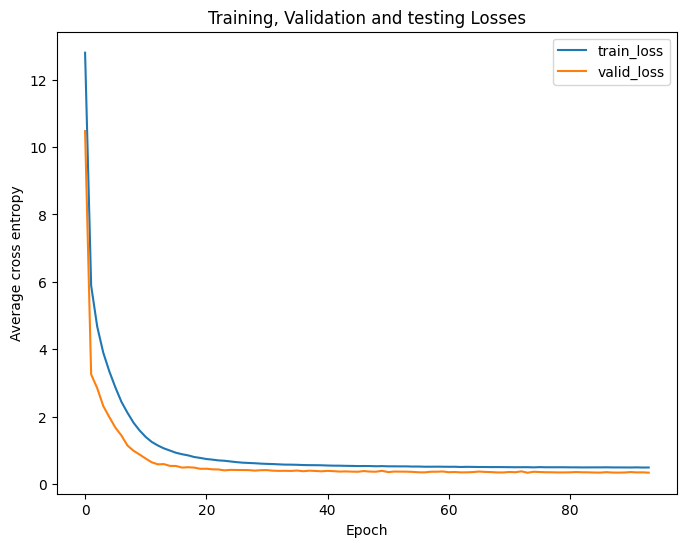

In [ ]:
model, history = train_mlp()

In [ ]:
def evaluate(model_path):
    X_train_scaled, X_test_scaled, y_train, y_test, df_copy = load_location_metadata_data(combined_data_path, include_capacity=True, include_shelter_id=True)
    train_dataset = DefaultDataset(X_train_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_train), axis=-1)))
    test_dataset = DefaultDataset(X_test_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_test), axis=-1)))

    x, y = train_dataset[10]
    input_shape = x.shape[0]
    model = MLP(input_shape, 1)
    model.eval()
    model.load_state_dict(torch.load(model_path))
    y_pred = model(torch.from_numpy(X_test_scaled.to_numpy()).float())
    y_pred = y_pred.detach().numpy()
    y_pred = np.squeeze(np.exp(y_pred))
    df_copy['PRED_SC'] = y_pred
    plt.figure(figsize=(8, 6))
    plt.plot(df_copy.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum())
    plt.plot(df_copy.groupby('OCCUPANCY_DATE')['PRED_SC'].sum())
    plt.legend(['Actual', 'Predicted'])
    plt.xlabel('Day')
    plt.ylabel('Average user count')
    plt.title('Evaluation of predicted user counts')
    plt.savefig('./mlp_model_log_loc_feat_shelid_cap_eval.jpg')

<ipython-input-84-bdd0dc5895d8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
<ipython-input-84-bdd0dc5895d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
<ipython-input-84-bdd0dc5895d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

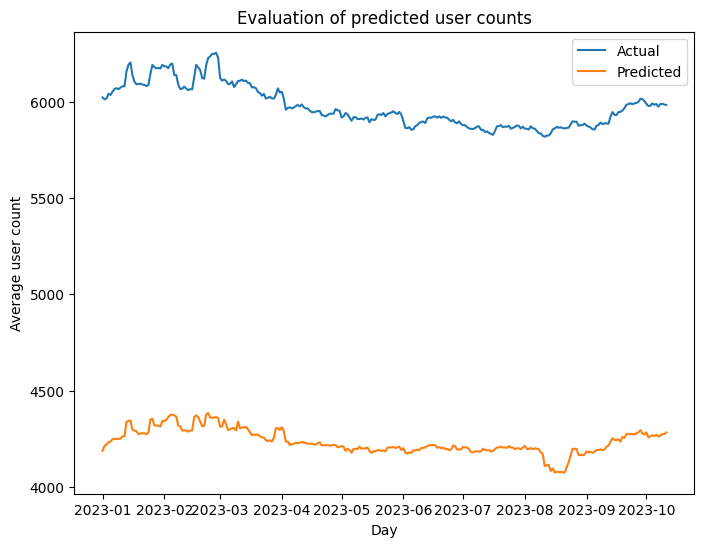

In [ ]:
evaluate('/content/mlp_model_log_loc_feat_shelid_cap.pt')

# Transformer

In [9]:
class TimeModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, seq_len):
        super(TimeModel, self).__init__()

        # self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.fc0 = nn.Linear(input_dim, 256)
        self.fc1 = nn.Linear(256, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, max_len=1)
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, batch_first=True, dropout=0.3)
        encoder_norm = nn.LayerNorm(hidden_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers, encoder_norm)
        self.fc_dec = nn.Linear(hidden_dim, 256)
        self.fc_dec2 = nn.Linear(256, 32)
        self.fc = nn.Linear(32*seq_len, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        # x = self.embedding(x)
        # print('x:', x[:2, :, :])
        x = self.fc0(x)
        x = torch.nn.ReLU()(x)
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        # print('x:', x[:2, :, :])
        x = self.positional_encoding(x)
        # print('x:', x[:2, :, :])
        x = self.encoder(x)
        # print('x:', x[:2, :, :])
        # print('x:', x[:2, :, :])
        x = torch.nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = self.fc_dec(x)
        x = torch.nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = self.fc_dec2(x)
        x = torch.nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # print('x:', x.shape)
        # print('self.pe:', self.pe.shape)
        x = x + self.pe[:, :x.size(1), :]
        return x

In [10]:
class SequenceDataset(Dataset):
    def __init__(self, data_x, data_y, window=30):
        # self.x = torch.from_numpy(data_x)
        # self.y = torch.from_numpy(data_y)
        cols = [col for col in data_x.columns if col[0]!='V']
        data_cols = [col for col in data_x.columns]
        data_cols.remove("OCCUPANCY_DATE")
        self.data_cols = data_cols
        cols.remove("OCCUPANCY_DATE")
        cols.remove("SERVICE_USER_COUNT")
        cols.remove("MONTH")
        cols.remove("DAY")
        data_x["GNUM"] = data_x.groupby(cols).ngroup()
        data_x["LOG_CNT"] = data_y
        self.x = data_x
        self.cumsum = np.cumsum(np.clip((data_x.groupby("GNUM").count()["OCCUPANCY_DATE"].to_numpy() - window), a_min=0, a_max=None))
        self.length = self.cumsum[-1]
        self.window = window
        self.gnum_subsets = []
        for gnum in self.x["GNUM"]:
            subset = self.x[self.x["GNUM"]==gnum]
            self.gnum_subsets.append((subset[self.data_cols], np.expand_dims(subset["LOG_CNT"].to_numpy(), axis=-1)))

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        diff = self.cumsum-index
        gnum = np.argmax(diff>0)
        if gnum==0:
          g_idx = index
        else:
          g_idx = index-self.cumsum[gnum-1]
        # subset_x, subset_y  = self.gnum_subsets[gnum]
        return torch.from_numpy(self.gnum_subsets[gnum][0].to_numpy())[g_idx:g_idx+self.window].float(), torch.from_numpy(self.gnum_subsets[gnum][1])[g_idx+self.window].float()

In [63]:
class SlowSequenceDataset(Dataset):
    def __init__(self, data_x, data_y, window=30):
        # self.x = torch.from_numpy(data_x)
        # self.y = torch.from_numpy(data_y)
        cols = [col for col in data_x.columns if col[0]!='V']
        data_cols = [col for col in data_x.columns]
        data_cols.remove("OCCUPANCY_DATE")
        self.data_cols = data_cols
        cols.remove("OCCUPANCY_DATE")
        cols.remove("SERVICE_USER_COUNT")
        cols.remove("MONTH")
        cols.remove("DAY")
        data_x["GNUM"] = data_x.groupby(cols).ngroup()
        data_x["LOG_CNT"] = data_y
        data_x['index_col'] = list(data_x.index)
        self.x = data_x
        self.cumsum = np.cumsum(np.clip((data_x.groupby("GNUM").count()["OCCUPANCY_DATE"].to_numpy() - window), a_min=0, a_max=None))
        self.length = self.cumsum[-1]
        self.window = window
        # self.gnum_subsets = []
        # for gnum in self.x["GNUM"]:
        #     subset = self.x[self.x["GNUM"]==gnum]
        #     self.gnum_subsets.append((subset[self.data_cols],))

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        diff = self.cumsum-index
        gnum = np.argmax(diff>0)
        if gnum==0:
          g_idx = index
        else:
          g_idx = index-self.cumsum[gnum-1]
        subset = self.x[self.x["GNUM"]==gnum]
        # print(subset["index_col"])
        return torch.from_numpy(subset[self.data_cols].to_numpy())[g_idx:g_idx+self.window].float(), torch.from_numpy(np.expand_dims(subset["LOG_CNT"].to_numpy(), axis=-1))[g_idx+self.window].float(), subset["index_col"].to_numpy()[g_idx+self.window], subset.iloc[g_idx:g_idx+self.window]
        # subset_x, subset_y  = self.gnum_subsets[gnum]
        # return torch.from_numpy(self.gnum_subsets[gnum][0].to_numpy())[g_idx:g_idx+self.window].float(), torch.from_numpy(self.gnum_subsets[gnum][1])[g_idx+self.window].float()
    def get_gid(self, index):
        diff = self.cumsum-index
        gnum = np.argmax(diff>0)
        if gnum==0:
          g_idx = index
        else:
          g_idx = index-self.cumsum[gnum-1]
        return g_idx

    def get_df(self):
        return self.x

    def get_gnum(self, index):
        diff = self.cumsum-index
        gnum = np.argmax(diff>0)
        return gnum

    def get_df_index(self, index):
        gnum = self.get_gnum(index)
        gidx = self.get_gid(index)
        subset = self.x[self.x["GNUM"]==gnum]
        return subset["index_col"][gidx+self.window]

In [64]:
open_eval('/content/trans_model_log.pt')

<ipython-input-26-dd981977055a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
<ipython-input-26-dd981977055a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
<ipython-input-26-dd981977055a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

input shape 131


  0%|          | 0/26358 [00:00<?, ?it/s]

     OCCUPANCY_DATE  SHELTER_ID  LOCATION_ID  SERVICE_USER_COUNT        V0  \
71       2023-01-01   -1.307519     -1.26052            0.105271 -1.327764   
178      2023-01-02   -1.307519     -1.26052            0.105271 -1.327764   
285      2023-01-03   -1.307519     -1.26052            0.105271 -1.327764   
392      2023-01-04   -1.307519     -1.26052            0.105271 -1.327764   
499      2023-01-05   -1.307519     -1.26052            0.105271 -1.327764   
606      2023-01-06   -1.307519     -1.26052            0.105271 -1.327764   
713      2023-01-07   -1.307519     -1.26052            0.105271 -1.327764   
820      2023-01-08   -1.307519     -1.26052            0.105271 -1.327764   
927      2023-01-09   -1.307519     -1.26052            0.064804 -1.327764   
1034     2023-01-10   -1.307519     -1.26052            0.044570 -1.327764   
1141     2023-01-11   -1.307519     -1.26052            0.024336 -1.327764   
1248     2023-01-12   -1.307519     -1.26052            0.024336

ValueError: ignored

In [ ]:
model = TimeModel(140,
                      hidden_dim=512,
                      num_layers=2,
                      num_heads=4,
                      output_dim=1,
                      seq_len=30)
x = torch.randn((128, 30, 140))
print(model)
print(model(x).shape)

TimeModel(
  (fc0): Linear(in_features=140, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (fc_dec): Linear(in_features=512, out_featur

In [26]:
def load_sequence_data(data_path):
    all_shelter_data = pd.read_csv(data_path, low_memory=False)
    all_shelter_data['OCCUPANCY_DATE'] = pd.to_datetime(all_shelter_data['OCCUPANCY_DATE'])
    toronto_data = all_shelter_data[all_shelter_data["LOCATION_CITY"] == "Toronto"]
    toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
    toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
    toronto_data['YEAR'] = toronto_data['OCCUPANCY_DATE'].dt.year
    # df[df["LOCATION_CITY"]=="Toronto"].groupby(["OCCUPANCY_DATE", "LOCATION_ID", "SHELTER_ID", "SECTOR", "PROGRAM_MODEL", "CAPACITY_TYPE"])
    drop_cols = ['_id', 'ORGANIZATION_ID', 'ORGANIZATION_NAME', 'SHELTER_GROUP',
                 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_ID',
                 'PROGRAM_NAME', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'CAPACITY_FUNDING_BED',
                 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS',
                 'OCCUPANCY_RATE_ROOMS', "OCCUPANCY_RATE_BEDS", 'UNAVAILABLE_BEDS','UNAVAILABLE_ROOMS',
                 "LOCATION_POSTAL_CODE", "Neighbourhood", "Neighbourhood Number", 'LAT', 'LON',
                 'CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM'
                 ]
    toronto_data_dr = toronto_data.drop(columns=drop_cols)
    toronto_data_dr_nan = toronto_data_dr[toronto_data_dr["PROGRAM_MODEL"].notna()]
    # Creating list of dummy columns
    to_get_dummies_for = ['SECTOR']
    # Creating dummy variables
    toronto_data_dr_nan = pd.get_dummies(data=toronto_data_dr_nan, columns=to_get_dummies_for)

    # Mapping overtime and attrition
    dict_prog_mod = {'Emergency': 1, 'Transitional': 0}
    dict_cap_type = {'Bed Based Capacity': 1, 'Room Based Capacity': 0}

    toronto_data_dr_nan['prog_mod'] = toronto_data_dr_nan["PROGRAM_MODEL"].map(dict_prog_mod)
    toronto_data_dr_nan['cap_type'] = toronto_data_dr_nan["CAPACITY_TYPE"].map(dict_cap_type)
    toronto_data_dr_nan = toronto_data_dr_nan.drop(columns=["PROGRAM_MODEL", "CAPACITY_TYPE"])


    final_df = toronto_data_dr_nan
    occu_final_df = toronto_data_dr_nan
    occu_final_df = occu_final_df[occu_final_df['YEAR']==2023]
    info = {"test_dated": occu_final_df.reset_index(drop=True)}
    final_df = final_df.fillna(value=0.0)
    test = final_df[final_df['YEAR']==2023]
    train = final_df[(final_df['YEAR']==2021) | (final_df['YEAR']==2022)]
    train = train.drop(columns=['YEAR'])
    test = test.drop(columns=['YEAR'])
    X_train, X_test, y_train, y_test = train, test, train['SERVICE_USER_COUNT'], test['SERVICE_USER_COUNT']
    sc = StandardScaler()
    # print(list(X_train.select_dtypes(include=['object']).columns))
    # Fit_transform on train data
    cols = list(X_train.columns)
    cols.remove("OCCUPANCY_DATE")
    X_train[cols] = sc.fit_transform(X_train[cols])

    # Transform on test data
    X_test[cols] = sc.transform(X_test[cols])
    info["scaler"] = sc

    return X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True), info

In [21]:
def train_seq():
    X_train_scaled, X_test_scaled, y_train, y_test, info = load_sequence_data(combined_data_path)
    train_dataset = SlowSequenceDataset(X_train_scaled, np.log(np.asarray(y_train)))
    test_dataset = SlowSequenceDataset(X_test_scaled, np.log(np.asarray(y_test)))

    x, y = train_dataset[10]
    input_shape = x.shape[1]
    print(f"input shape {input_shape}")
    model = TimeModel(input_shape,
                      hidden_dim=512,
                      num_layers=1,
                      num_heads=4,
                      output_dim=1,
                      seq_len=30).to("cuda")
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-5)
    model, history = train(
        model,
        criterion,
        optimizer,
        train_dataloader,
        test_dataloader,
        save_file_name='./trans_model_log.pt',
        max_epochs_stop=50,
        n_epochs=100,
        print_every=1)

    plot_loss(history, "./loss.jpg")
    return model, history

In [22]:
train_seq()

<ipython-input-14-0b26a8a686e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
<ipython-input-14-0b26a8a686e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
<ipython-input-14-0b26a8a686e1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

input shape 131
Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.9039 	Validation Loss: 0.7654

Epoch: 1 	Training Loss: 0.4347 	Validation Loss: 0.5582

Epoch: 2 	Training Loss: 0.2559 	Validation Loss: 0.3484

Epoch: 3 	Training Loss: 0.2129 	Validation Loss: 0.3064

Epoch: 4 	Training Loss: 0.1930 	Validation Loss: 0.2867

Epoch: 5 	Training Loss: 0.1760 	Validation Loss: 0.2600

Epoch: 6 	Training Loss: 0.1657 	Validation Loss: 0.2537

Epoch: 7 	Training Loss: 0.1534 	Validation Loss: 0.2311

Epoch: 8 	Training Loss: 0.1420 	Validation Loss: 0.2157

Epoch: 9 	Training Loss: 0.1299 	Validation Loss: 0.1959

Epoch: 10 	Training Loss: 0.1187 	Validation Loss: 0.1826

Epoch: 11 	Training Loss: 0.1094 	Validation Loss: 0.1889

Epoch: 12 	Training Loss: 0.1030 	Validation Loss: 0.1748

Epoch: 13 	Training Loss: 0.0992 	Validation Loss: 0.1724

Epoch: 14 	Training Loss: 0.0964 	Validation Loss: 0.1718

Epoch: 15 	Training Loss: 0.0925 	Validation Loss: 0.1671

Epoch: 16 	Train

KeyboardInterrupt: ignored

In [79]:
import tqdm
def open_eval(model_path):
    X_train_scaled, X_test_scaled, y_train, y_test, info = load_sequence_data(combined_data_path)
    cols = list(X_train_scaled.columns)
    cols.remove("OCCUPANCY_DATE")
    train_dataset = SlowSequenceDataset(X_train_scaled, np.log(np.asarray(y_train)))
    test_dataset = SlowSequenceDataset(X_test_scaled, np.log(np.asarray(y_test)))

    x, y, _, _ = train_dataset[10]
    input_shape = x.shape[1]
    print(f"input shape {input_shape}")
    model = TimeModel(input_shape,
                      hidden_dim=512,
                      num_layers=1,
                      num_heads=4,
                      output_dim=1,
                      seq_len=30).to("cuda")
    model.eval()
    model.load_state_dict(torch.load(model_path))
    sc = info["scaler"]
    alt_cols = list(map(lambda x: x.replace('SERVICE_USER_COUNT', 'UNSCALED_SC'), cols))
    test_dataset.x["UNSCALED_SC"] = y_test
    for i in tqdm.tqdm(range(len(test_dataset))):
        _, _, idx, ss = test_dataset[i]
        ss[cols] = sc.inverse_transform(ss[cols])
        ss = ss.drop(columns=["SERVICE_USER_COUNT"])
        ss = ss.rename(columns={"UNSCALED_SC": "SERVICE_USER_COUNT"})
        input = sc.transform(ss[cols])
        y_pred = model(torch.unsqueeze(torch.from_numpy(input), dim=0).to("cuda").float())
        test_dataset.x["UNSCALED_SC", idx] = np.exp(torch.squeeze(y_pred.detach()).to("cpu").item())
    test_dataset.x["ACTUAL"] = y_test
    plt.figure(figsize=(8, 6))
    plt.plot(test_dataset.x.groupby('OCCUPANCY_DATE')['ACTUAL'].sum())
    plt.plot(test_dataset.x.groupby('OCCUPANCY_DATE')['UNSCALED_SC'].sum())
    plt.legend(['Actual', 'Predicted'])
    plt.xlabel('Day')
    plt.ylabel('Average user count')
    plt.title('Evaluation of predicted user counts')
    plt.savefig('./trans_model_eval.jpg')




def closed_eval(model_path):
    X_train_scaled, X_test_scaled, y_train, y_test, df_copy = load_sequence_data(combined_data_path)
    train_dataset = DefaultDataset(X_train_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_train), axis=-1)))
    test_dataset = DefaultDataset(X_test_scaled.to_numpy(), np.log(np.expand_dims(np.asarray(y_test), axis=-1)))

    x, y = train_dataset[10]
    input_shape = x.shape[0]
    model = MLP(input_shape, 1)
    model.eval()
    model.load_state_dict(torch.load(model_path))
    y_pred = model(torch.from_numpy(X_test_scaled.to_numpy()).float())
    y_pred = y_pred.detach().numpy()
    y_pred = np.squeeze(np.exp(y_pred))
    # df_copy['PRED_SC'] = y_pred
    # plt.figure(figsize=(8, 6))
    # plt.plot(df_copy.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum())
    # plt.plot(df_copy.groupby('OCCUPANCY_DATE')['PRED_SC'].sum())
    # plt.legend(['Actual', 'Predicted'])
    # plt.xlabel('Day')
    # plt.ylabel('Average user count')
    # plt.title('Evaluation of predicted user counts')
    # plt.savefig('./mlp_model_log_loc_feat_shelid_cap_eval.jpg')


In [80]:
open_eval('/content/trans_model_log.pt')

<ipython-input-26-dd981977055a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
<ipython-input-26-dd981977055a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
<ipython-input-26-dd981977055a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

input shape 131


  2%|▏         | 652/26358 [01:18<1:10:55,  6.04it/s]<ipython-input-79-3a9f55d67775>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss[cols] = sc.inverse_transform(ss[cols])
  3%|▎         | 670/26358 [01:21<1:12:03,  5.94it/s]<ipython-input-79-3a9f55d67775>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss[cols] = sc.inverse_transform(ss[cols])
  4%|▍         | 1013/26358 [02:29<1:48:05,  3.91it/s]<ipython-input-79-3a9f55d67775>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

KeyboardInterrupt: ignored

In [13]:
X_train_scaled, X_test_scaled, y_train, y_test, info = load_sequence_data(combined_data_path)
cols = [col for col in X_train_scaled.columns if col[0]!='V']
print(cols)

<ipython-input-10-0b26a8a686e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
<ipython-input-10-0b26a8a686e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
<ipython-input-10-0b26a8a686e1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

['OCCUPANCY_DATE', 'SHELTER_ID', 'LOCATION_ID', 'SERVICE_USER_COUNT', 'MONTH', 'DAY', 'SECTOR_Families', 'SECTOR_Men', 'SECTOR_Mixed Adult', 'SECTOR_Women', 'SECTOR_Youth', 'prog_mod', 'cap_type']


In [14]:
cols.remove("OCCUPANCY_DATE")
cols.remove("SERVICE_USER_COUNT")
cols.remove("MONTH")
cols.remove("DAY")

In [17]:
X_train_scaled["GNUM"] = X_train_scaled.groupby(cols).ngroup()

In [28]:
(X_train_scaled.groupby("GNUM").count()["OCCUPANCY_DATE"]-30).cumsum()

GNUM
0        700
1       1400
2       2100
3       2520
4       3679
       ...  
129    73553
130    73601
131    73616
132    73814
133    73790
Name: OCCUPANCY_DATE, Length: 134, dtype: int64

In [31]:
cumsum = np.cumsum(np.clip((X_train_scaled.groupby("GNUM").count()["OCCUPANCY_DATE"].to_numpy() - 30), a_min=0, a_max=None))

In [15]:
X_train_scaled, X_test_scaled, y_train, y_test, info = load_sequence_data(combined_data_path)
train_dataset = SlowSequenceDataset(X_train_scaled, np.log(np.asarray(y_train)))
test_dataset = SlowSequenceDataset(X_test_scaled, np.log(np.asarray(y_test)))


<ipython-input-14-0b26a8a686e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['MONTH'] = toronto_data['OCCUPANCY_DATE'].dt.month
<ipython-input-14-0b26a8a686e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data['DAY'] = toronto_data['OCCUPANCY_DATE'].dt.day
<ipython-input-14-0b26a8a686e1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [37]:
(cumsum-66718)>0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,